<a href="https://colab.research.google.com/github/margaridanferreira/LAB/blob/devel/Assignment_1_25_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Automation 2025/26 - Assignment 1

To be delivered until 2025-12-05 23:59:59.

**Submission Notes**:
- Create a folder in your group's GitHub repository to solve this assignment. Copy this notebook into that folder.
- You should commit regularly to your repository the answers to the questions in this notebook. If you do not, your grade will be penalized by 1/20 points.
- After running the entire notebook (including graphs and outputs), save the notebook as a .pdf file, by going to File - Print - Destination: Save as PDF.
- Create a .zip file containing both the .ipynb file (the notebook itself) and the .pdf and submit it in Fénix.

# Problem description

The dataset for this assignment contains information on students from two Portuguese secondary schools enrolled in a mathematics course.
Each row corresponds to one student and includes demographic and family background variables (e.g., basic personal and household characteristics), school-related variables (e.g., school context, study habits, past failures), behavioral and lifestyle indicators (e.g., free time, going out, alcohol use), and the grades for the three school periods, on a 0–20 scale.

The goal is to predict the performance of the students in the final period.
First, the problem will be approached as a classification task, predicting whether a student will pass (G3 >= 10) or fail (G3 < 10) the course.
Then, the problem will be approached as a regression task, predicting the actual final grade (G3).

A detailed description of all variables (family context, behavioral, school performance, etc.) is provided in the file `variable_description.txt`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import scipy as sp
import random

# Part 1 - Data exploration **(4.00)**

##### **1.1.** Load the dataset from the CSV file `mathematics_grades.csv`. **(0.25)**

In [3]:
data_m  = pd.read_csv("/content/mathematics_grades.csv")
data_m.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,failed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,True
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,True
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,False
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,False
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,False


##### **1.2.** Identify the feature types of each variable in the dataset. **(1.50)**

In [ ]:
data_m.dtypes

##### **1.3** Check if the dataset has missing values. If so, discard any row that has a missing value. **(0.25)**

In [4]:
missing_values_count = data_m.isnull().sum()
if missing_values_count.sum() > 0:
    print("Missing values found:")
    print(missing_values_count[missing_values_count > 0])
    initial_rows = data_m.shape[0]
    data_m.dropna(how="any", inplace=True)
    print(f"\nDropped {initial_rows - data_m.shape[0]} rows with missing values.")
    print(f"New DataFrame shape: {data_m.shape}")
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


##### **1.4.** Make a pairplot of the numerical variables, colored by the `failed` variable. **(0.50)**

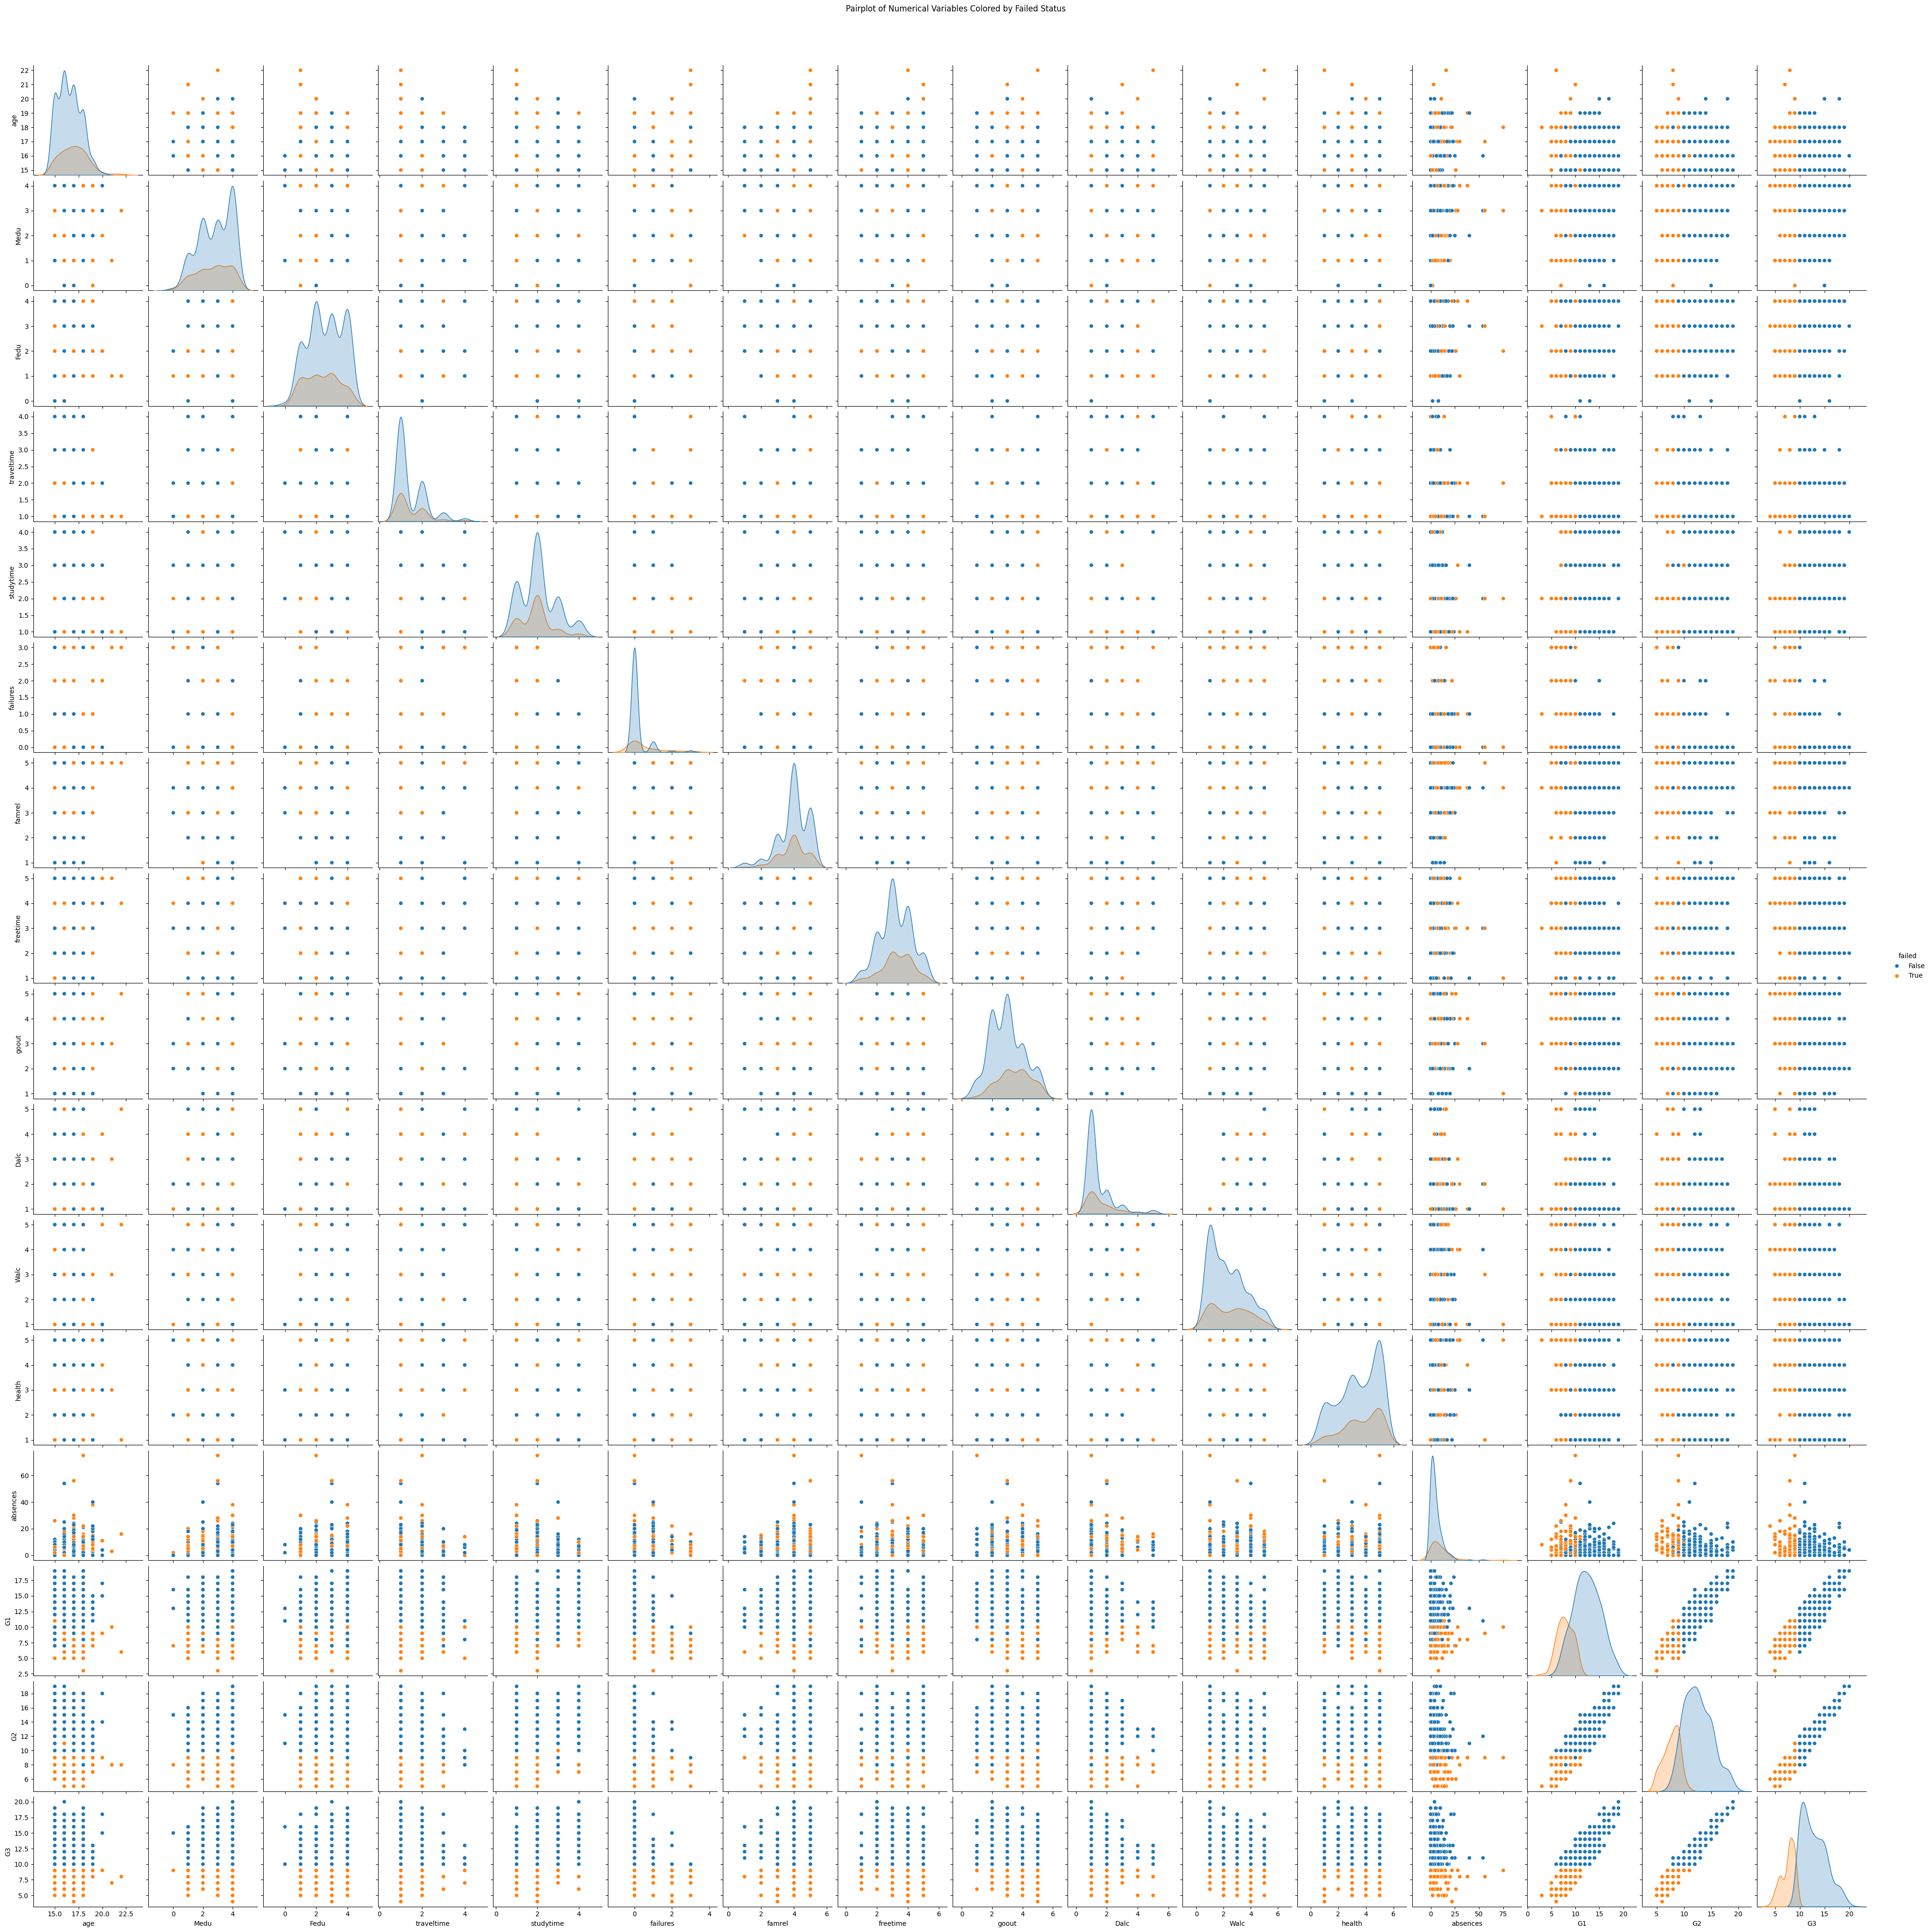

In [5]:
numerical_cols = data_m.select_dtypes(include=np.number).columns
sns.pairplot(data_m[numerical_cols.tolist() + ['failed']], hue='failed', diag_kind='kde')
plt.suptitle('Pairplot of Numerical Variables Colored by Failed Status', y=1.02)
plt.show()

##### **1.5.** Make bar plots for each categorical variable, showing the counts for each category, colored by the `failed` variable. **(0.50)**

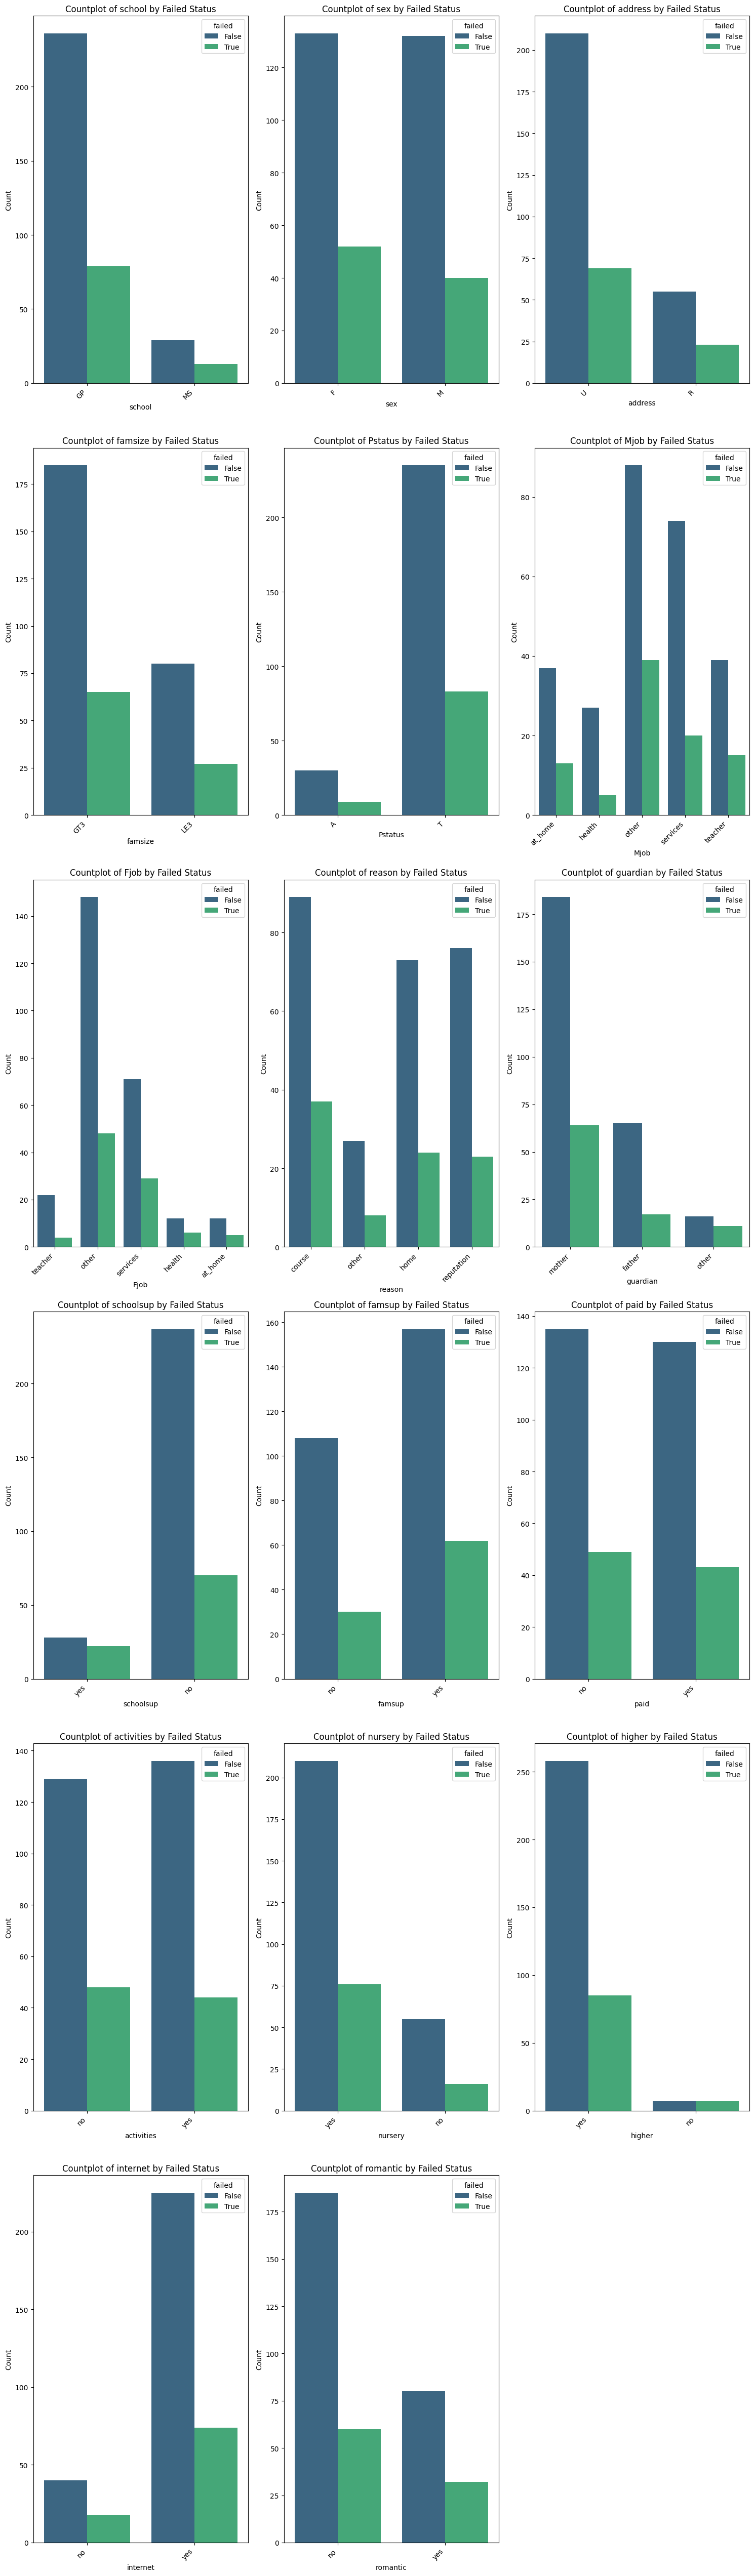

In [6]:
categorical_cols = data_m.select_dtypes(include='object').columns

plt.figure(figsize=(15, len(categorical_cols) * 3))
for i, col in enumerate(categorical_cols):
    plt.subplot(len(categorical_cols) // 3 + 1, 3, i + 1) # Adjust subplot grid dynamically
    sns.countplot(data=data_m, x=col, hue='failed', palette='viridis')
    plt.title(f'Countplot of {col} by Failed Status')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### **1.6.** In each school, how many students live in a rural area and do not have internet access at home? **(0.50)**

In [7]:
rural_no_internet = data_m[(data_m['address'] == 'R') & (data_m['internet'] == 'no')]
students_per_school = rural_no_internet.groupby('school').size().reset_index(name='count')
print("Number of students living in a rural area and without internet access, per school:")
print(students_per_school)

Number of students living in a rural area and without internet access, per school:
  school  count
0     GP     17
1     MS      7


##### **1.7.** Split the dataset into a training set (80%) and a test set (20%). **(0.50)**

In [9]:
from sklearn.model_selection import train_test_split

X = data_m.drop('failed', axis=1) # Features
y = data_m['failed'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data set size: {data_m.shape[0]} samples")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Data set size: 357 samples
Training set size: 285 samples
Test set size: 72 samples


# Part 2 - Classification **(7.50)**

##### You'll start by approaching the problem as a classification task, predicting whether a student will pass (G3 >= 10) or fail (G3 < 10) the course. Consider the variable `failed` as the target variable.

##### **2.1.** Which performance metric do you think are most important for this prediction task, and why? Justify your answer in the context of supporting students who may struggle academically. **(2.00)**

##### **2.2.** Build a logistic regression model to predict whether a student will pass or fail the course, using as predictor the feature `absences`. Evaluate the performance of the model on the test set using a confusion matrix, accuracy, precision, recall, f1-score and the metric you selected in question 2.1. **(0.50)**

##### **2.3.** The model you built in question 2.2 likely does not perform very well. Explain why this is the case, considering the distribution of the predictor and the response. How can you improve the model? **(2.00)**

##### **2.4.** Consider now the variable `studytime` as the predictor and assume it is numerical. Build a logistic regression model to predict whether a student will pass or fail the course. Evaluate the performance of the model on the test set using a confusion matrix, accuracy, precision, recall, f1-score and the metric you selected in question 2.1. **(0.50)**

Note: Use `sklearn.linear_model.LogisticRegression(class_weight='balanced')` for your logistic regression model.

##### **2.5.** Repeat question 2.4, but now considering `studytime` as a categorical variable. **(0.50)**

##### **2.6.** What is the difference between the two models you built in questions 2.4 and 2.5? Plot the predictions of each model over the range of `studytime` values in the test set. What are the advantages and disadvantages of each approach? **(2.00)**


# Part 3 - Regression (3.50)

##### In this part of the assignment, you'll approach the problem as a regression task, predicting the actual final grade `G3`. Use the same training and test sets you created in Part 1.

##### **3.1.** Build a linear regression model to predict the final grade `G3`, using as predictor the feature `G2`. Evaluate the performance of the model on the test set using Mean Squared Error (MSE) and R-squared ($R^2$). **(0.50)**

##### **3.2.** Print the equation of the model you built in question 3.1. Plot the predictions of the model as a function of the inputs, along with the actual data points from the test set. Interpret the coefficients of the model. **(1.00)**


##### **3.3.** Build a linear regression model to predict the final grade `G3`, using as predictors all features except the variables related to the grades (`G1`, `G2`, `G3`, `failed`). Explain the choices you made. Evaluate the performance of the model on the test set using Mean Squared Error (MSE) and R-squared ($R^2$). Plot the predicted vs actual values of `G3` for the test set. **(1.00)**

##### **3.4.** In terms of application, what is the difference between building a model to predict student performance using the grades of the previous periods (as in question 3.1) versus using other features (as in question 3.3)? When would each approach be more appropriate? **(1.00)**

# Part 4 - Cross-validation (4.00)

##### **4.1.** Explain the concept of cross-validation and its importance in evaluating machine learning models. **(1.00)**

##### **4.2.** Describe how K-fold cross-validation works. What values of K should be used? Justify. **(1.00)**

##### **4.3.** Explain how K-Fold cross-validation should be done to choose the classification threshold for the logistic regression model of Part 2. **(2.00)**

# Part 5 - GitHub (1.00)

##### **5.1.** Describe how your group used GitHub to track changes throughout the project and explain why maintaining a clear change history is important in data analysis and machine learning work. **(1.00)**